## Training with all datasets

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
from utils.plot_util import *
import os
import socket

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [12]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/2021-01-27-V24/*/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/2021-01-27-V24/*/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/2021-01-27-V24/*/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)

In [13]:
file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]

9_Phase_B-E_LEM1
ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>
Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>
Points:
(1085774,)
shift_opts_freqs_all:
(121, 1085774)


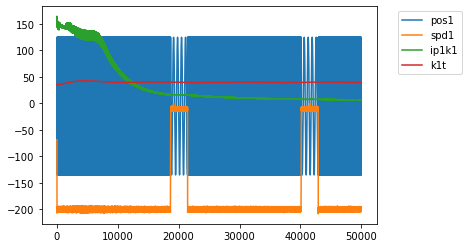

In [16]:
# check dataset 
file = file_list_LEM1[-1]
filename = file.split(os.sep)[-1][:-3]
pklName = DIR + '/data/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 
h51 = h5py.File(file, "r")

print(filename)
print("ATTR:")
print(h51.attrs.keys())
print("Keys:")
print(h51.keys())
print("Points:")
print(h51['t'].shape)
print("shift_opts_freqs_all:")
print(shift_opts_freqs_all.shape)

GT = ['pos1','spd1','ip1k1','k1t']
for gt in GT:
    plt.plot(h51[gt][:50000], label = gt)
plt.legend(bbox_to_anchor=(1.05, 1))

In [2]:
# extract data from all datasets
X = np.empty((0,242))
y = np.empty((0,))
pts_dataset = [0]
for file in file_list_LEM1:
    # filename = file.split('\\')[-1][:-3]
    filename = file.split('/')[-1][:-3]
    pklName = DIR +'/data/shift_opts_freqs_all/' + filename + '.pkl'
    shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 

    with h5py.File(file, "r") as h51:

        N = 100 # ignore first N points
        s21 = np.array(h51['S21_P1_LEM1'])
        dataset = []
        for j in range (121):
            index = np.arange(N,len(h51['t'])) - shift_opts_freqs_all[j,N:].round().astype(int)
            dataset.append(s21[index,j].real)
            dataset.append(s21[index,j].imag)

        _X = np.asarray(dataset).T
        _y = np.asarray(h51['ip1k1'][N:])
        pts_dataset.append(_X.shape[0])
        print(filename)
        print("_X:")
        print(_X.shape)
        print("_y:")
        print(_y.shape)
        print()
    X = np.vstack((X,_X))
    y = np.append(y,_y)
idx_dataset = np.cumsum(pts_dataset)
print("Final Dataset:")
print("X:")
print(X.shape)
print("y:")
print(y.shape)
print("index of each dataset:")
print(idx_dataset)

20210127_Phase_A-D_LEM1
_X:
(987776, 242)
_y:
(987776,)

20210201_3_Phase_B-E_LEM1
_X:
(1069640, 242)
_y:
(1069640,)

20210202_4_Phase_C-F_LEM1
_X:
(1088064, 242)
_y:
(1088064,)

20210218_5_Phase_A-D_LEM1
_X:
(1069443, 242)
_y:
(1069443,)

20210218_7_Phase_C-F_LEM1
_X:
(1050535, 242)
_y:
(1050535,)

9_Phase_B-E_LEM1
_X:
(1085674, 242)
_y:
(1085674,)

Final Dataset:
X:
(6351132, 242)
y:
(6351132,)
index of the last point of each dataset:
[ 987776 2057416 3145480 4214923 5265458 6351132]


In [18]:
# # # save data
# pickle.dump( X, open( DIR + "/data/training_data/X.pkl", "wb" ))
# pickle.dump( y, open( DIR + "/data/training_data/y.pkl", "wb" ))
# # load data
X = pickle.load( open( DIR + "/data/training_data/X.pkl", "rb" ) )
y = pickle.load( open( DIR + "/data/training_data/y.pkl", "rb" ) )
idx_dataset = np.array('0 987776 2057416 3145480 4214923 5265458 6351132'.split()).astype(int)

In [10]:
print("Final Dataset:")
print("X:")
print(X.shape)
print("y:")
print(y.shape)
print("index of the last point of each dataset:")
print(idx_dataset)

Final Dataset:
X:
(6351132, 242)
y:
(6351132,)
index of the last point of each dataset:
[      0  987776 2057416 3145480 4214923 5265458 6351132]


In [15]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

# indices2 = np.arange(X_train.shape[0])
# X_train2, X_val, y_train2, y_val, idx_train2, idx_val = train_test_split(X_train, y_train, indices2, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

print(X_train.shape)
print(X_test.shape)

(5080905, 242)
(1270227, 242)


### Baseline model with normalization

In [16]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [17]:
def baseline_model_norm(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [18]:
NN_norm = baseline_model_norm(normalizer)
NN_norm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,910
Trainable params: 39,425
Non-trainable params: 485
_________________________________________________________________


In [20]:
%%time
history = NN_norm.fit(
    X_train, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=2, epochs=100)

Epoch 1/100
63512/63512 - 70s - loss: 44.2077 - val_loss: 30.3695
Epoch 2/100
63512/63512 - 68s - loss: 16.9693 - val_loss: 11.2817
Epoch 3/100
63512/63512 - 68s - loss: 11.6165 - val_loss: 10.0651
Epoch 4/100
63512/63512 - 69s - loss: 9.0603 - val_loss: 8.6834
Epoch 5/100
63512/63512 - 69s - loss: 7.6790 - val_loss: 6.6154
Epoch 6/100
63512/63512 - 69s - loss: 6.4970 - val_loss: 7.2887
Epoch 7/100
63512/63512 - 69s - loss: 5.7675 - val_loss: 5.8185
Epoch 8/100
63512/63512 - 69s - loss: 5.3188 - val_loss: 4.8387
Epoch 9/100
63512/63512 - 68s - loss: 4.7929 - val_loss: 4.5638
Epoch 10/100
63512/63512 - 69s - loss: 4.5364 - val_loss: 3.8531
Epoch 11/100
63512/63512 - 69s - loss: 4.2155 - val_loss: 3.4071
Epoch 12/100
63512/63512 - 69s - loss: 3.9829 - val_loss: 7.1019
Epoch 13/100
63512/63512 - 69s - loss: 3.7843 - val_loss: 3.4985
Epoch 14/100
63512/63512 - 69s - loss: 3.5342 - val_loss: 5.7156
Epoch 15/100
63512/63512 - 69s - loss: 3.4051 - val_loss: 3.3120
Epoch 16/100
63512/63512 - 6

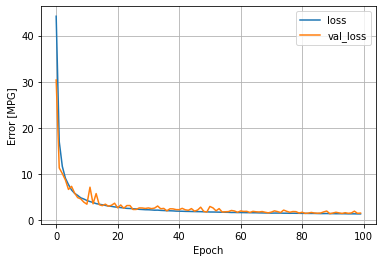

In [21]:
plot_loss(history)

In [22]:
# Collect the results on the test set
NN_norm.evaluate(X_test, y_test,verbose = 0)

1.5145113468170166

In [23]:
# X_ = scaler.fit_transform(X)
y_ = NN_norm.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [65]:
num = 5 # dataset number starting from 0
filename = file_list_LEM1[num].split('/')[-1][:-3]
interval = np.arange(idx_dataset[num],idx_dataset[num+1])
idx_train_temp = [i-idx_dataset[num] for i in idx_train_sort if i >= idx_dataset[num] and i<idx_dataset[num+1]]
idx_test_temp = [i-idx_dataset[num] for i in idx_test_sort if i >= idx_dataset[num] and i<idx_dataset[num+1]]
com_train = np.intersect1d(idx_train_sort, interval)
com_test = np.intersect1d(idx_test_sort, interval)

9_Phase_B-E_LEM1


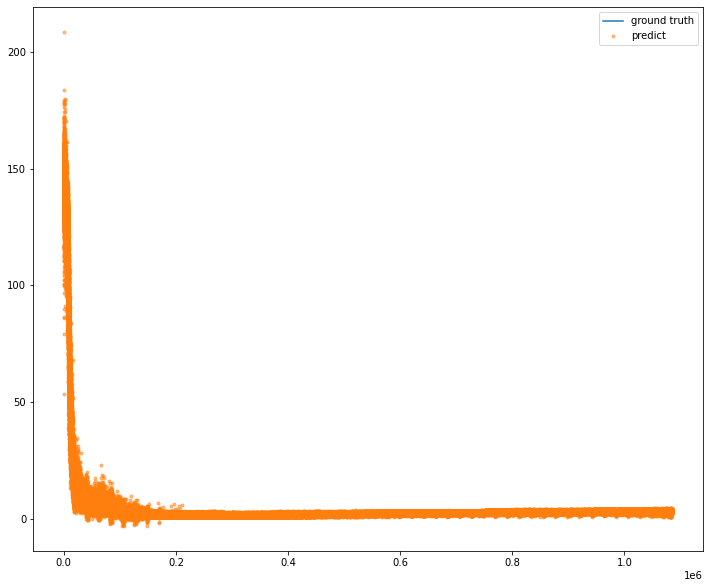

In [66]:
# predictioin vs ground truth in one plot
%matplotlib inline

print(filename)
plot_gt_pre_overlap(y[interval],y_[interval])

9_Phase_B-E_LEM1


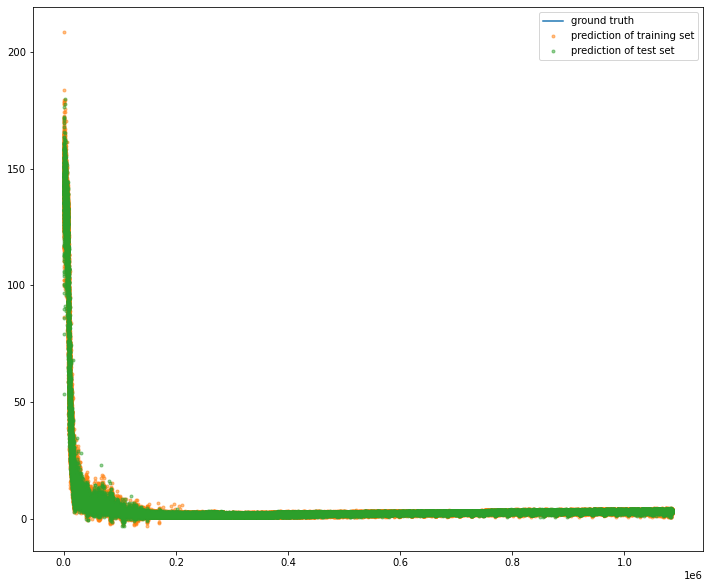

In [67]:
# (predictioin for X_test and X_train separately) vs (ground truth)  in one plot
%matplotlib inline
print(filename)
plot_gt_pre_sep(y[interval],idx_train_temp,y_[com_train],idx_test_temp,y_[com_test])

In [42]:
NN_norm.save(DIR + "/models/NN_norm_all")

INFO:tensorflow:Assets written to: /home/xin/projects/trelleborg/models/NN_norm_all/assets


In [12]:
# NN_norm = tf.keras.models.load_model(DIR + "/models/NN_norm")

## An alternative way to split the dataset: leave one out

In [ ]:
X = pickle.load( open( DIR + "/data/training_data/X.pkl", "rb" ) )
y = pickle.load( open( DIR + "/data/training_data/y.pkl", "rb" ) )
idx_dataset = np.array('0 987776 2057416 3145480 4214923 5265458 6351132'.split()).astype(int)

In [14]:
i = idx_dataset[-2]
X_train = X[:i]
X_test = X[i:]
y_train = y[:i]
y_test = y[i:]
idx_train_sort = np.arange(i)
idx_test_sort = np.arange(i,y.shape[0])

print(X_train.shape)
print(X_test.shape)

(5265458, 242)
(1085674, 242)


In [16]:
def baseline_model_norm(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN_norm = baseline_model_norm(normalizer)
NN_norm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,910
Trainable params: 39,425
Non-trainable params: 485
_________________________________________________________________


In [17]:
%%time
history = NN_norm.fit(
    X_train, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=1, epochs=100)

Wall time: 3h 3min 54s


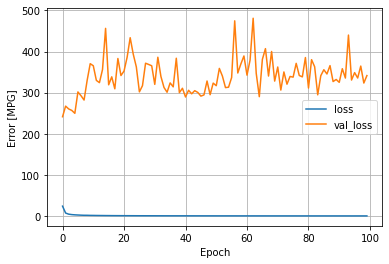

In [18]:
plot_loss(history)

In [19]:
NN_norm.save(DIR + "/models/NN_norm_all_loo")

INFO:tensorflow:Assets written to: C:/Users/xin/OneDrive - bwstaff/xin/trelleborg/models/NN_norm_all_loo\assets


In [20]:
# Collect the results on the test set
NN_norm.evaluate(X_test, y_test,verbose = 0)

420.13739013671875

In [21]:
# X_ = scaler.fit_transform(X)
y_ = NN_norm.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

No handles with labels found to put in legend.
C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\scripts\training\utils\plot_util.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


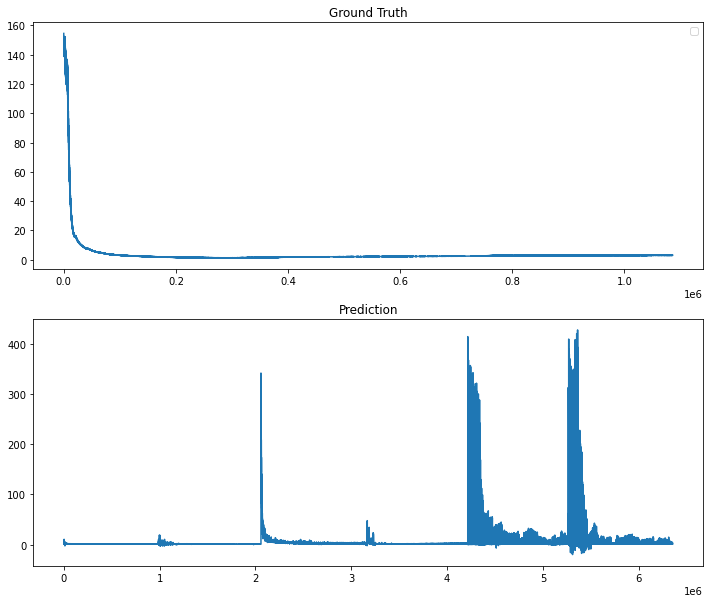

In [22]:
%matplotlib inline
plot_gt_pre(y[idx_test_sort],y_)

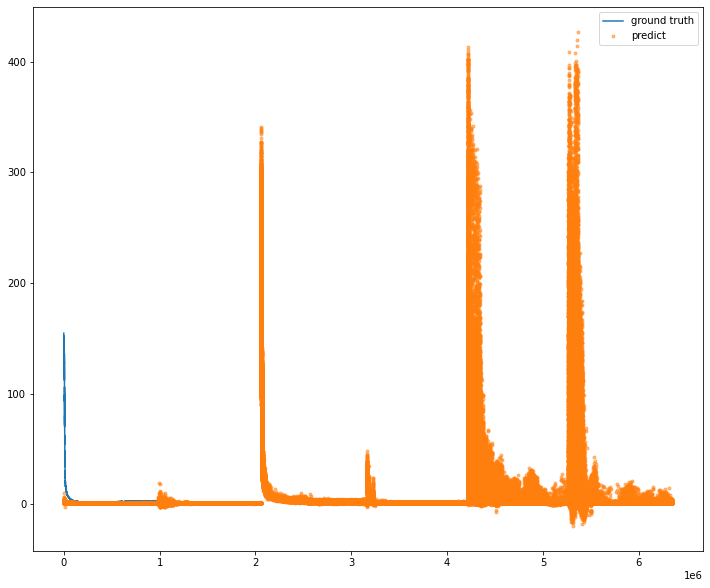

In [23]:
# predictioin vs ground truth in one plot
%matplotlib inline
plot_gt_pre_overlap(y[idx_test_sort],y_)

### sigmoid actiation


In [19]:
i = idx_dataset[-2]
X_train = X[:i]
X_test = X[i:]
y_train = y[:i]
y_test = y[i:]
idx_train_sort = np.arange(i)
idx_test_sort = np.arange(i,y.shape[0])

print(X_train.shape)
print(X_test.shape)

(5265458, 242)
(1085674, 242)


In [20]:
def baseline_model_norm_sig(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='sigmoid'),
      layers.Dense(64, kernel_initializer='normal',activation='sigmoid'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN_norm = baseline_model_norm_sig(normalizer)
NN_norm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,910
Trainable params: 39,425
Non-trainable params: 485
_________________________________________________________________


In [21]:
%%time
history = NN_norm.fit(
    X_train, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 3h 1min 28s


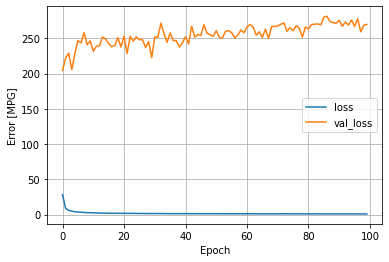

In [22]:
plot_loss(history)

In [23]:
NN_norm.save(DIR + "/models/NN_norm_all_loo_sig")

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg/models/NN_norm_all_loo_sig\assets


In [24]:
# Collect the results on the test set
NN_norm.evaluate(X_test, y_test,verbose = 0)

483.6519775390625

In [25]:
# X_ = scaler.fit_transform(X)
y_ = NN_norm.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

No handles with labels found to put in legend.
C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\scripts\training\utils\plot_util.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


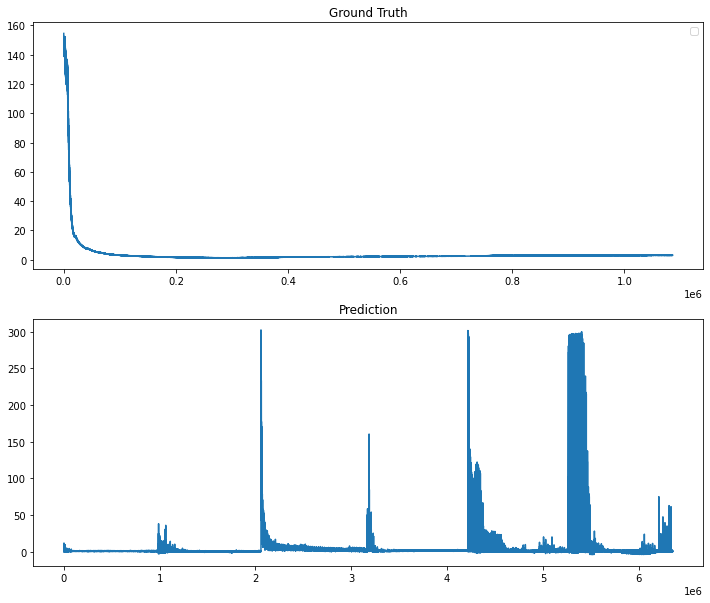

In [26]:
%matplotlib inline
plot_gt_pre(y[idx_test_sort],y_)

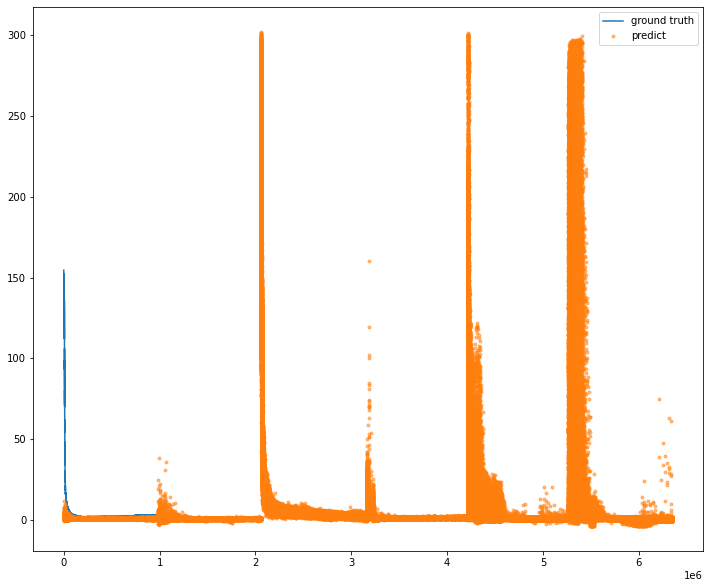

In [27]:
# predictioin vs ground truth in one plot
%matplotlib inline
plot_gt_pre_overlap(y[idx_test_sort],y_)

### bigger model

In [28]:
def model_4(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(256, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(128, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN_norm = model_4(normalizer)
NN_norm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               62208     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 105,958
Trainable params: 105,473
Non-trainable params: 485
______________________________________________

In [29]:
%%time
history = NN_norm.fit(
    X_train, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
65819/65819 [==============================] - 187s 3ms/step - loss: 42.2637 - val_loss: 238.1730
Epoch 2/100
65819/65819 [==============================] - 185s 3ms/step - loss: 9.2126 - val_loss: 207.0329
Epoch 3/100
65819/65819 [==============================] - 190s 3ms/step - loss: 5.6249 - val_loss: 175.7555
Epoch 4/100
65819/65819 [==============================] - 190s 3ms/step - loss: 4.3230 - val_loss: 210.7795
Epoch 5/100
65819/65819 [==============================] - 185s 3ms/step - loss: 3.1785 - val_loss: 186.4059
Epoch 6/100
65819/65819 [==============================] - 187s 3ms/step - loss: 2.9284 - val_loss: 186.5290
Epoch 7/100
65819/65819 [==============================] - 185s 3ms/step - loss: 2.6815 - val_loss: 191.7178
Epoch 8/100
65819/65819 [==============================] - 185s 3ms/step - loss: 2.3274 - val_loss: 177.0874
Epoch 9/100
65819/65819 [==============================] - 184s 3ms/step - loss: 1.8695 - val_loss: 192.6734
Epoch 10/100
65819

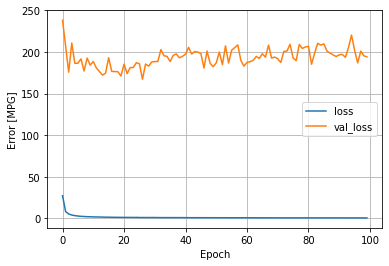

In [30]:
plot_loss(history)

In [31]:
NN_norm.save(DIR + "/models/NN_norm_all_loo_4")

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg/models/NN_norm_all_loo_4\assets


In [32]:
# Collect the results on the test set
NN_norm.evaluate(X_test, y_test,verbose = 0)

566.2723999023438

In [33]:
# X_ = scaler.fit_transform(X)
y_ = NN_norm.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

No handles with labels found to put in legend.
C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\scripts\training\utils\plot_util.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2, 1, 1)


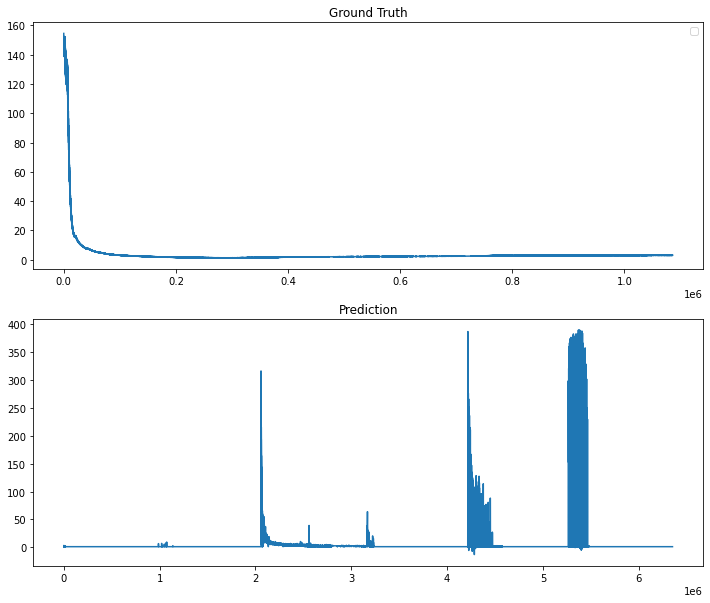

In [34]:
%matplotlib inline
plot_gt_pre(y[idx_test_sort],y_)

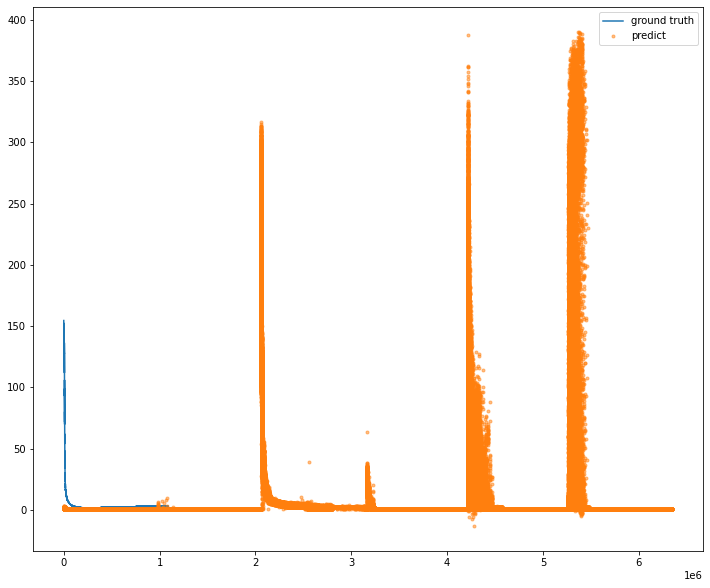

In [35]:
# predictioin vs ground truth in one plot
%matplotlib inline
plot_gt_pre_overlap(y[idx_test_sort],y_)